# San Francisco Crime Classification

Authors: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.sql.functions import *

### Load the data

In [33]:
sfcrime = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path","bigdata/dataset/train.csv").load()
                    
#TODO scaricare anche test set e fare una gunzione unica per preprocessing di entrambi i dataset

In [3]:
sfcrime.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [6]:
# Visualize the data
sfcrime.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

### Data Preprocessing

Steps done in preprocessing:
- feature extraction and pruning
- TODO: transform to categorical dayofweek and pdDiscrit?
- drop duplicate rows
- null removal
- outliers removal

In [34]:
# feature extraction and pruning:
# 1. extract the hour of the day from the timestamp
# 2. extract the month from the timestamp
# 3. extract the year from the timestamp
# 4. drop the 'Dates' column


sfcrime = sfcrime.withColumn('Hour', hour("Dates"))
sfcrime = sfcrime.withColumn('Month', month("Dates"))
sfcrime = sfcrime.withColumn('Year', year("Dates"))
sfcrime = sfcrime.drop("Dates")


In [7]:
# drop duplicate rows
prev_count = sfcrime.count()
sfcrime = sfcrime.dropDuplicates()
print("Number of duplicated rows: ", prev_count - sfcrime.count())

Number of duplicated rows:  2323


In [35]:
# nulls removal
sfcrime.na.drop()
print('Total number of records:', sfcrime.count())

Total number of records: 878049


In [10]:
'''
!pip3 install geopandas
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
'''

'\n!pip3 install geopandas\nimport geopandas as gpd\nfrom shapely.geometry import Point\nfrom geopandas import GeoDataFrame\nimport matplotlib.pyplot as plt\n'

In [11]:
# Outliers : https://www.kaggle.com/code/bananawolf/random-forest-knn-logistic-regression

'''
sfcrime_pd = sfcrime.toPandas()

geometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]
gdf = GeoDataFrame(sfcrime_pd, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(), marker='o', color='red')
plt.show()
'''

"\nsfcrime_pd = sfcrime.toPandas()\n\ngeometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]\ngdf = GeoDataFrame(sfcrime_pd, geometry=geometry)\n\nworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))\ngdf.plot(ax=world.plot(), marker='o', color='red')\nplt.show()\n"

From the previous image, we can observe that there are some erroneus coordinates that do not refer to San Francisco geographic coordinates. They may be due to mislabelling errors, and we consider them as outliers, therefore we remove them from the dataset. 

In [36]:
#sfcrime = sfcrime.drop(sfcrime[(sfcrime.X > -122) | (sfcrime.X < -123) | (sfcrime.Y > 38) | (sfcrime.Y < 37)].iloc)
prev_count = sfcrime.count()
sfcrime = sfcrime.where((sfcrime.X < -122) & (sfcrime.X > -123) & (sfcrime.Y < 38) & (sfcrime.Y > 37))
print("Number of outliers: ", prev_count - sfcrime.count())

Number of outliers:  67


## Dataset requirements

In [11]:
# number of features
#TODO



In [12]:
# total number of patterns
print('Total number of records: ', sfcrime.count())

Total number of records:  875659


In [13]:
#TODO: fare prodotto?

## Dataset inspection

### Distribution of crimes

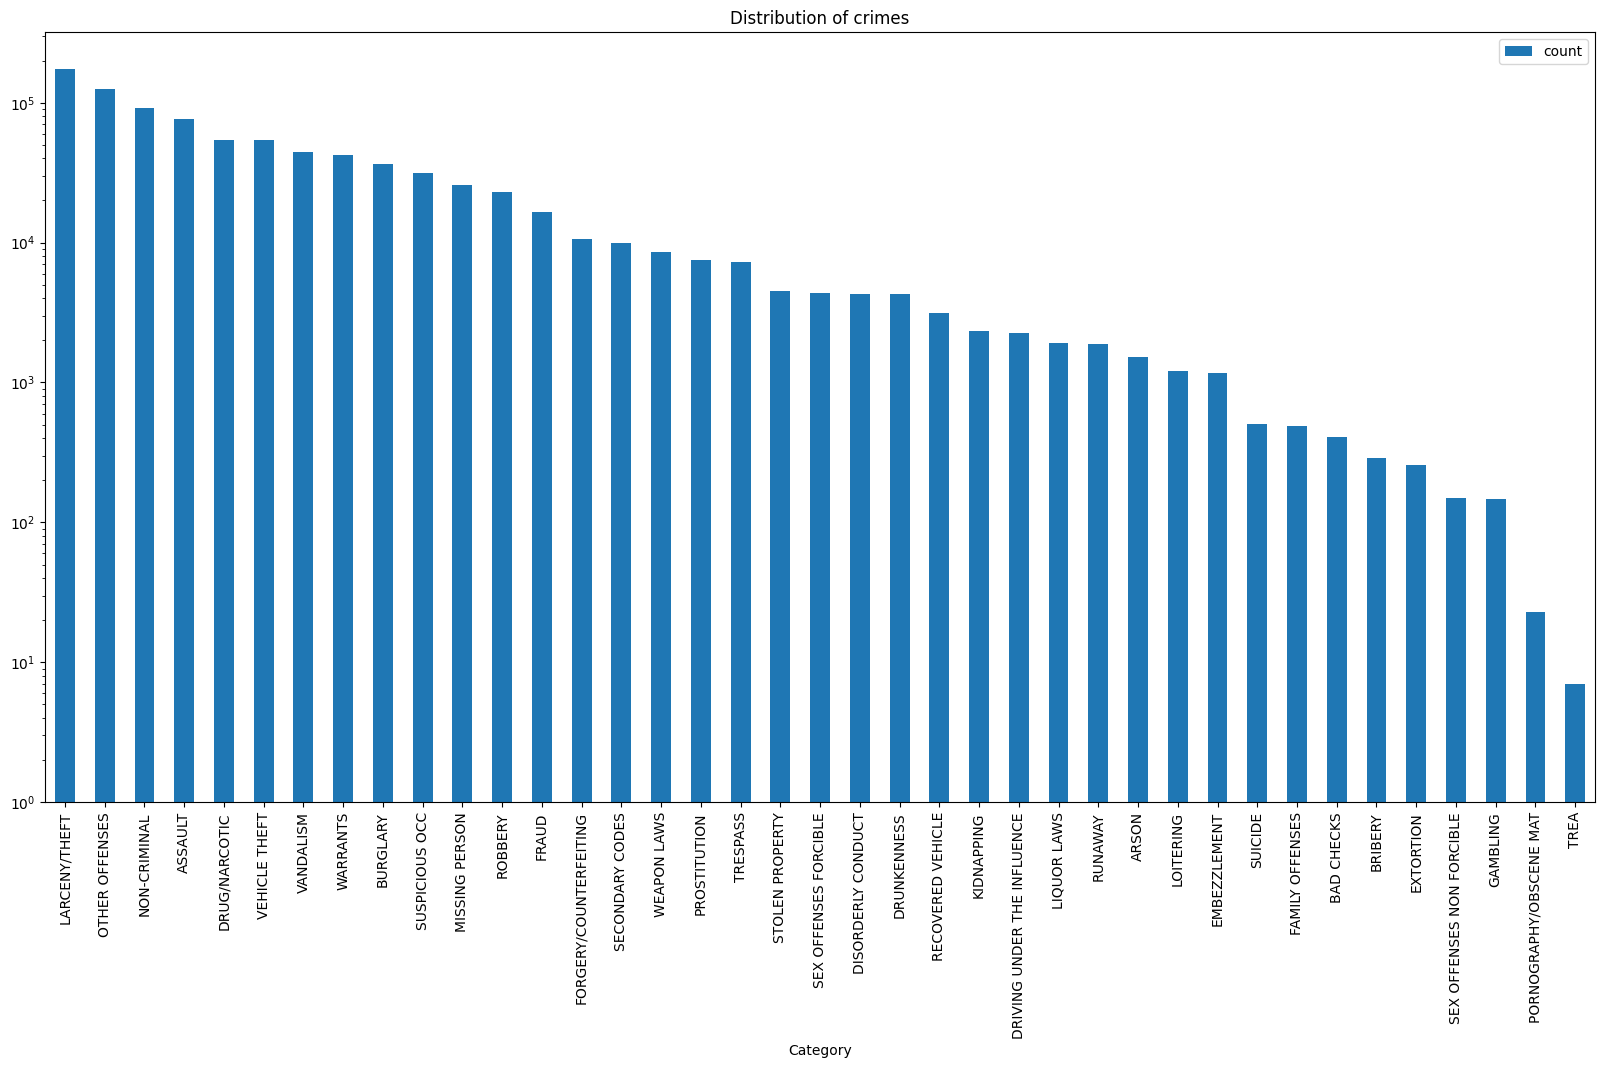

In [14]:
sfcrime.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
plt.title('Distribution of crimes')
plt.show()     

### Distributions of crimes among districts

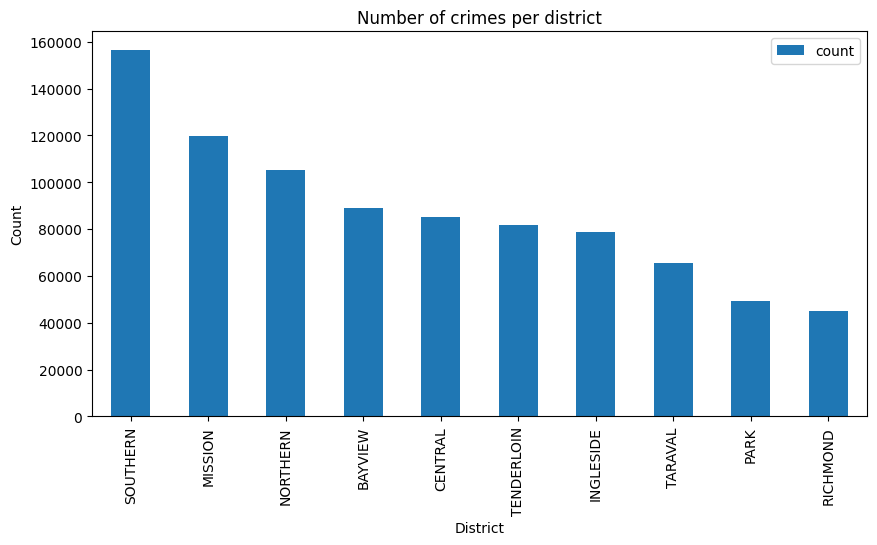

In [15]:
sfcrime.groupBy('PdDistrict').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='PdDistrict', y='count', figsize=(10, 5))
plt.title('Number of crimes per district')
plt.xlabel('District')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='PdDistrict'>

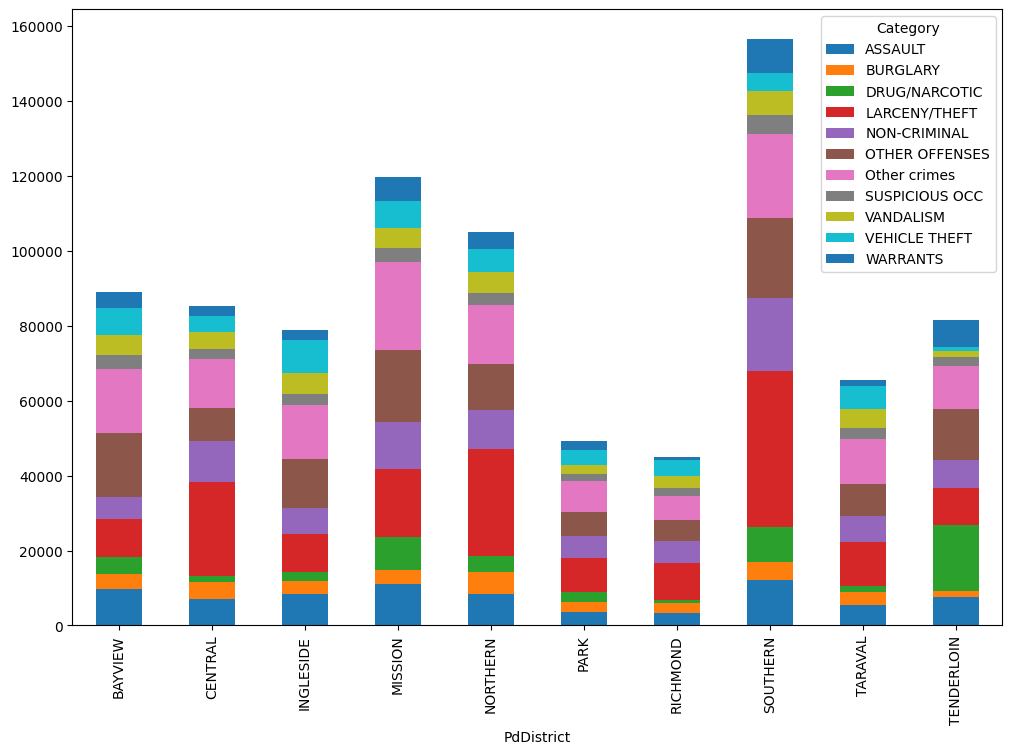

In [16]:
# Analyze the different categories of crimes per district
sfcrime_copy_top_10 = sfcrime.toPandas().copy()

# Select the top 10 crimes and group the rest into 'Other crimes'
top10 = sfcrime_copy_top_10['Category'].value_counts().head(10).index.tolist()
sfcrime_copy_top_10.loc[~sfcrime_copy_top_10['Category'].isin(top10), 'Category'] = 'Other crimes'

# Plot the number of crimes per district for each category
sfcrime_copy_top_10.groupby(['PdDistrict','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
            .plot(kind='bar',stacked=True,figsize=(12,8))


### Distribution of crimes among hours

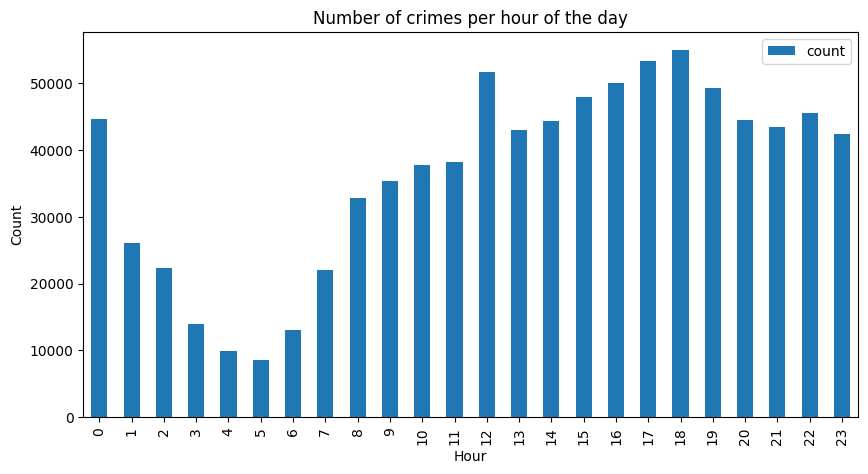

In [17]:
sfcrime.groupBy('Hour').count().orderBy('hour', ascending=True).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10, 5))
plt.title('Number of crimes per hour of the day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

### Distribution of crimes among days

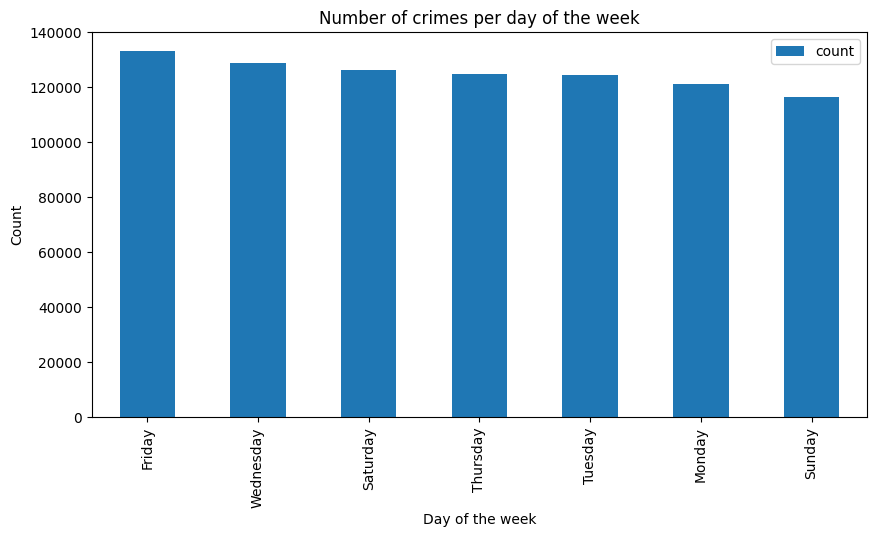

In [18]:
sfcrime.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
plt.title('Number of crimes per day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.show()

In [19]:
sfcrime_copy = sfcrime.toPandas().copy()

In [20]:
# function for weekly trend per category 

def weekly_trend(category):
    sfcrime_category = sfcrime_copy[sfcrime_copy['Category']==category]
    sfcrime_category.groupby(['DayOfWeek','Category'])\
                .agg({'Resolution':'count'})\
                .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
                .plot(kind='line',figsize=(8,5))
    plt.title('Weekly trend of the category: ' + category)
    plt.xlabel('Day of the week')
    plt.ylabel('Count')
    plt.show()


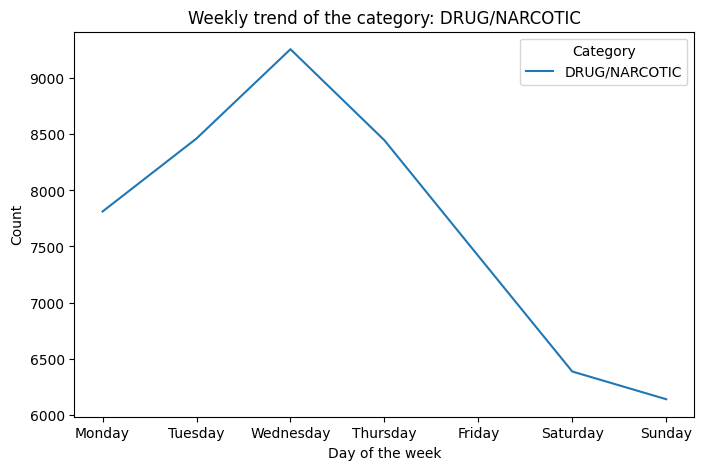

"sfcrime_drug = sfcrime_copy[sfcrime_copy['Category']=='DRUG/NARCOTIC']\nsfcrime_drug.groupby(['DayOfWeek','Category'])            .agg({'Resolution':'count'})            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])            .plot(kind='line',figsize=(8,5))"

In [21]:
# Trend of the category 'DRUG/NARCOTIC' for each day of the week

weekly_trend('DRUG/NARCOTIC')

'''sfcrime_drug = sfcrime_copy[sfcrime_copy['Category']=='DRUG/NARCOTIC']
sfcrime_drug.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))'''

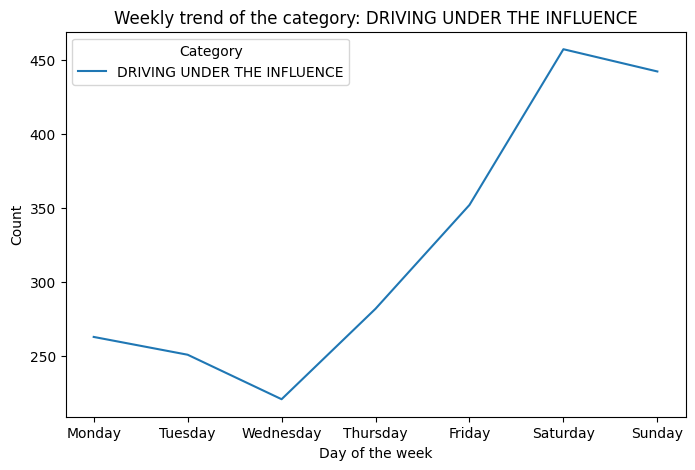

"sfcrime_drive = sfcrime_copy[sfcrime_copy['Category']=='DRIVING UNDER THE INFLUENCE']\nsfcrime_drive.groupby(['DayOfWeek','Category'])            .agg({'Resolution':'count'})            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])            .plot(kind='line',figsize=(8,5))"

In [22]:
# Trend of the category 'DRIVING UNDER THE INFLUENCE' for each day of the week

weekly_trend('DRIVING UNDER THE INFLUENCE')

'''sfcrime_drive = sfcrime_copy[sfcrime_copy['Category']=='DRIVING UNDER THE INFLUENCE']
sfcrime_drive.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))'''

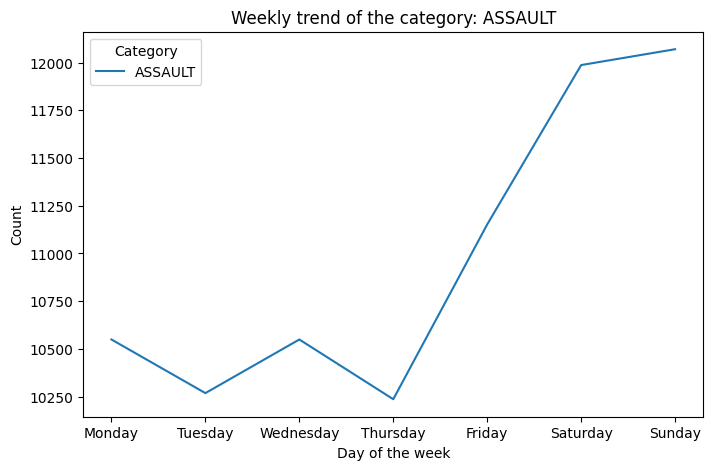

"sfcrime_assault = sfcrime_copy[sfcrime_copy['Category']=='ASSAULT']\nsfcrime_assault.groupby(['DayOfWeek','Category'])            .agg({'Resolution':'count'})            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])            .plot(kind='line',figsize=(8,5))"

In [23]:
# Trend of the category 'ASSAULT' for each day of the week

weekly_trend('ASSAULT')

'''sfcrime_assault = sfcrime_copy[sfcrime_copy['Category']=='ASSAULT']
sfcrime_assault.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))'''

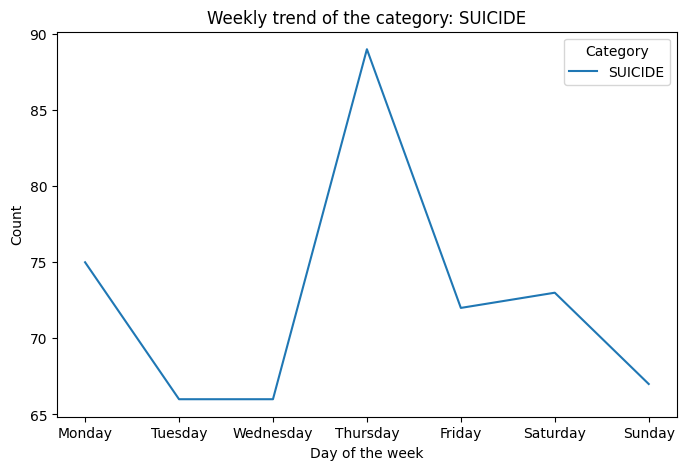

"sfcrime_suicide = sfcrime_copy[sfcrime_copy['Category']=='SUICIDE']\nsfcrime_suicide.groupby(['DayOfWeek','Category'])            .agg({'Resolution':'count'})            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])            .plot(kind='line',figsize=(8,5))"

In [24]:
# Trend of the category 'SUICIDE' for each day of the week

weekly_trend('SUICIDE')

'''sfcrime_suicide = sfcrime_copy[sfcrime_copy['Category']=='SUICIDE']
sfcrime_suicide.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))'''

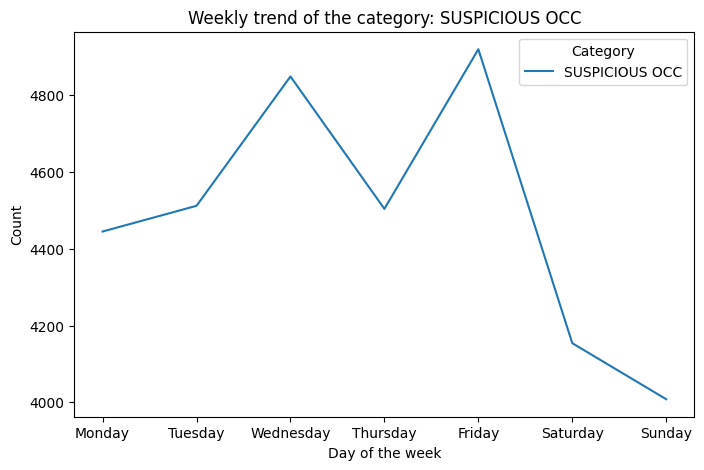

"sfcrime_occ = sfcrime_copy[sfcrime_copy['Category']=='SUSPICIOUS OCC']\nsfcrime_occ.groupby(['DayOfWeek','Category'])            .agg({'Resolution':'count'})            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])            .plot(kind='line',figsize=(8,5))"

In [25]:
# Trend of the category 'SUSPICIOUS OCC' for each day of the week
weekly_trend('SUSPICIOUS OCC')
'''sfcrime_occ = sfcrime_copy[sfcrime_copy['Category']=='SUSPICIOUS OCC']
sfcrime_occ.groupby(['DayOfWeek','Category'])\
            .agg({'Resolution':'count'})\
            .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
            .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
            .plot(kind='line',figsize=(8,5))'''

### Distribution of crimes among years

<Axes: xlabel='Year'>

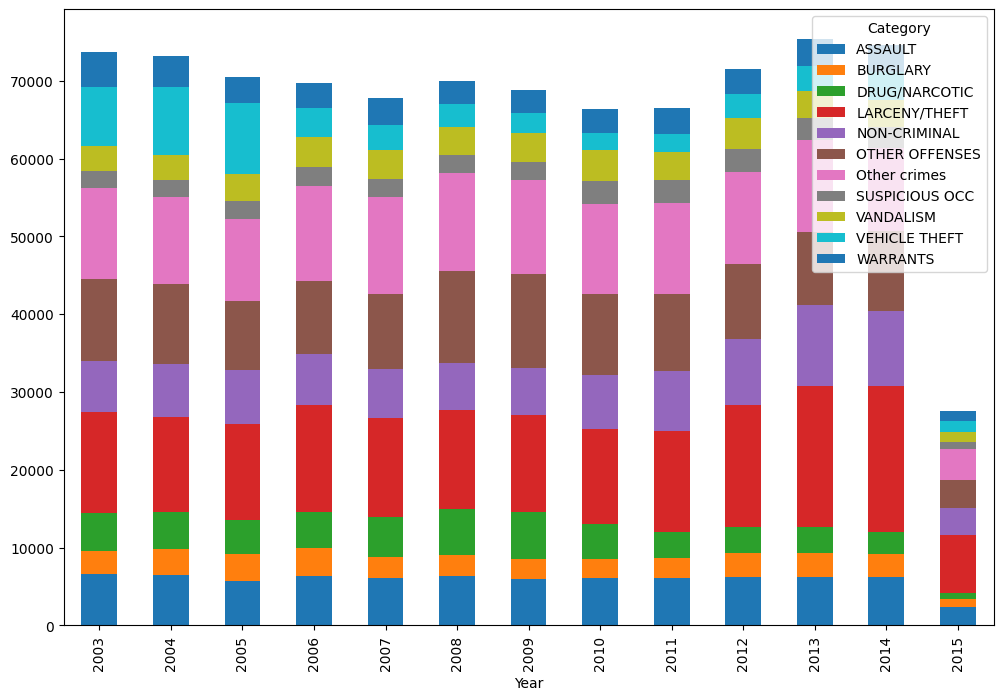

In [26]:
# Plot the number of crimes per year for each category
sfcrime_copy_top_10.groupby(['Year','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='Year',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))

In 2015 there is a drop in the number of crimes because the dataset contains the crimes until may 2015. We drop all the records where year is 2015

In [53]:
# TODO: perche nel 2015 cosi pochi?

Number of records:  848137


Number of records:  848137


### Distribution of crimes among different addresses

<Axes: xlabel='Address'>

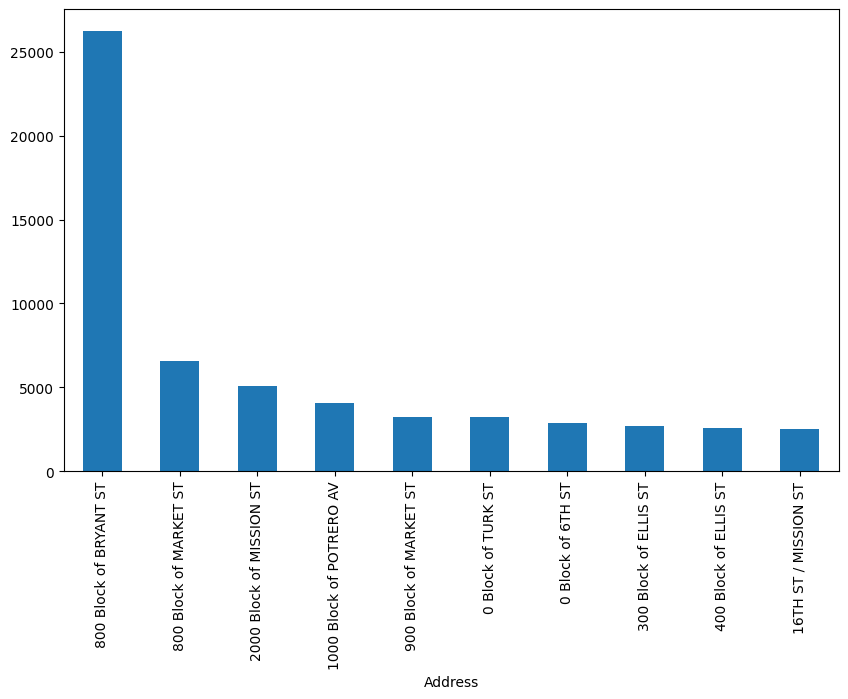

In [28]:
# Show the addresses where the most crimes have been committed
sfcrime_copy_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))


#### TODO: la maggior parte hanno la parola block quindi magari è importante ecc.. e si puo aggiungere come feauture togliendo l'address

In [29]:
# How the crimes have been resolved?


In [30]:
'''
#Street number extraction as integer value
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def street_no(address):
    try:
        return int(address.split(' ')[0])
    except:
        return 0

street_no_udf = udf(street_no, IntegerType())
df = sfcrime.withColumn('StreetNo', street_no_udf(sfcrime['Address']))
df.show()
'''

"\n#Street number extraction as integer value\nfrom pyspark.sql.functions import udf\nfrom pyspark.sql.types import IntegerType\n\ndef street_no(address):\n    try:\n        return int(address.split(' ')[0])\n    except:\n        return 0\n\nstreet_no_udf = udf(street_no, IntegerType())\ndf = sfcrime.withColumn('StreetNo', street_no_udf(sfcrime['Address']))\ndf.show()\n"

In [38]:
#Block feature extraction: 1 if block present, 0 otherwise

sfcrime = sfcrime.withColumn('Block', when(sfcrime.Address.like("%Block%") , lit(1)).otherwise(lit(0)))
sfcrime.show()

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|Hour|Month|Year|Block|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -12

#### To categorical

In [39]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

# Create a StringIndexer to convert the 'color' column to numerical
indexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_cat")
sfcrime = indexer.fit(sfcrime).transform(sfcrime)

#drop previous column pdDisctrict
sfcrime = sfcrime.drop("PdDistrict")

# Show the results
sfcrime.show()


+-------------------+--------------+--------------------+---------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+
|              Dates|      Category|            Descript|DayOfWeek|    Resolution|             Address|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|
+-------------------+--------------+--------------------+---------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|ARREST, BOOKED|VANNESS AV / GREE.

In [40]:

# Create a StringIndexer to convert the 'color' column to numerical
indexer = StringIndexer(inputCol="Category", outputCol="Category_cat")
sfcrime = indexer.fit(sfcrime).transform(sfcrime)

#drop previous column pdDisctrict
sfcrime = sfcrime.drop("Category")

# Show the results
sfcrime.show()

+-------------------+--------------------+---------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+------------+
|              Dates|            Descript|DayOfWeek|    Resolution|             Address|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|Category_cat|
+-------------------+--------------------+---------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+------------+
|2015-05-13 23:53:00|      WARRANT ARREST|Wednesday|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         7.0|
|2015-05-13 23:53:00|TRAFFIC VIOLATION...|Wednesday|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         1.0|
|2015-05-13 23:33:00|TRAFFIC VIOLATION...|Wednesday|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  

In [41]:

# Create a StringIndexer to convert the 'color' column to numerical
indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_cat")
sfcrime = indexer.fit(sfcrime).transform(sfcrime)

#drop previous column pdDisctrict
sfcrime = sfcrime.drop("DayOfWeek")

# Show the results
sfcrime.show()

+-------------------+--------------------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+
|              Dates|            Descript|    Resolution|             Address|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|Category_cat|DayOfWeek_cat|
+-------------------+--------------------+--------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+
|2015-05-13 23:53:00|      WARRANT ARREST|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         7.0|          1.0|
|2015-05-13 23:53:00|TRAFFIC VIOLATION...|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         1.0|          1.0|
|2015-05-13 23:33:00|TRAFFIC VIOLATION...|ARREST, BOOKED|VANNESS AV / GREE...|   -122.4243

In [ ]:
#vedere quanti sono i valori unici di resolution e decidere se fare to categorical o meno
sfcrime.select(countDistinct("Resolution")).show()

In [42]:
# Create a StringIndexer to convert the 'color' column to numerical
indexer = StringIndexer(inputCol="Resolution", outputCol="Resolution_cat")
sfcrime = indexer.fit(sfcrime).transform(sfcrime)

#drop previous column pdDisctrict
sfcrime = sfcrime.drop("Resolution")

# Show the results
sfcrime.show()


+-------------------+--------------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+
|              Dates|            Descript|             Address|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|Category_cat|DayOfWeek_cat|Resolution_cat|
+-------------------+--------------------+--------------------+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+
|2015-05-13 23:53:00|      WARRANT ARREST|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         7.0|          1.0|           1.0|
|2015-05-13 23:53:00|TRAFFIC VIOLATION...|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|
|2015-05-13 23:33:00|TRAFFIC VIOLATION...|VANNESS AV / GREE...|   -122.42436302145|  37.80

In [44]:
#preprocess Descript column with tokenizer
from pyspark.ml.feature import Tokenizer

# Create a Tokenizer
tokenizer = Tokenizer(inputCol="Descript", outputCol="Descript_token")

# Transform DataFrame
sfcrime = tokenizer.transform(sfcrime)

#Drop descript
sfcrime = sfcrime.drop("Descript")

# Show DataFrame
sfcrime.show()

+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+--------------------+
|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|Category_cat|DayOfWeek_cat|Resolution_cat|      Descript_token|
+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+--------------------+
|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         7.0|          1.0|           1.0|   [warrant, arrest]|
|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|[traffic, violati...|
|   -122.42436302145|  37.8004143219856|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|[traffic, violati...|
|-122.42699532676599| 37.80087263276921|  23|    5|2015|    1|           2.0|         0.0|          1.0|           0.0|[grand, theft, fr...|
|  -122.43873

In [46]:
#print distinct values for dayofweek
sfcrime.select(countDistinct("DayOfWeek_cat")).show()

+-----------------------------+
|count(DISTINCT DayOfWeek_cat)|
+-----------------------------+
|                            7|
+-----------------------------+



In [47]:
#transform description_token with count vector
from pyspark.ml.feature import CountVectorizer

# Create a CountVectorizer
vectorizer = CountVectorizer(inputCol="Descript_token", outputCol="Descript_vec")

# Fit the model
model = vectorizer.fit(sfcrime)

# Transform the data
sfcrime = model.transform(sfcrime)

#Drop descript token
sfcrime = sfcrime.drop("Descript_token")

# Show the results
sfcrime.show()

+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+--------------------+
|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|Category_cat|DayOfWeek_cat|Resolution_cat|        Descript_vec|
+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+--------------------+
|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         7.0|          1.0|           1.0|(1086,[15,29],[1....|
|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|(1086,[12,15,32],...|
|   -122.42436302145|  37.8004143219856|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|(1086,[12,15,32],...|
|-122.42699532676599| 37.80087263276921|  23|    5|2015|    1|           2.0|         0.0|          1.0|           0.0|(1086,[0,2,3,4,5]...|
|  -122.43873

In [64]:
#drop address since we already have x and y coordinates
sfcrime = sfcrime.drop("Address")
sfcrime.show()

+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+--------------------+
|                  X|                 Y|Hour|Month|Year|Block|PdDistrict_cat|Category_cat|DayOfWeek_cat|Resolution_cat|        Descript_vec|
+-------------------+------------------+----+-----+----+-----+--------------+------------+-------------+--------------+--------------------+
|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         7.0|          1.0|           1.0|(1086,[15,29],[1....|
|  -122.425891675136|  37.7745985956747|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|(1086,[12,15,32],...|
|   -122.42436302145|  37.8004143219856|  23|    5|2015|    0|           2.0|         1.0|          1.0|           1.0|(1086,[12,15,32],...|
|-122.42699532676599| 37.80087263276921|  23|    5|2015|    1|           2.0|         0.0|          1.0|           0.0|(1086,[0,2,3,4,5]...|
|  -122.43873

In [34]:
#TODO provare a guardare anche i giorni del mese ed eventualmente fare colonna binaria con holiday

## Models 
Exam:
- KNN 
- XGB classifier 
- Decision tree
- Random forest
- Bayesian 

PW:


In [48]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import RFormula

In [49]:
rf = RFormula(formula="Category_cat ~ .")
rf_fit = rf.fit(sfcrime)
rf_transformed = rf_fit.transform(sfcrime)
rf_transformed.printSchema()

sfcrime_train = rf_transformed.selectExpr("features", "label")



root
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Block: integer (nullable = false)
 |-- PdDistrict_cat: double (nullable = false)
 |-- Category_cat: double (nullable = false)
 |-- DayOfWeek_cat: double (nullable = false)
 |-- Resolution_cat: double (nullable = false)
 |-- Descript_vec: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [50]:
sfcrime_train.rdd.getNumPartitions()

4

In [51]:
sfcrime_train = sfcrime_train.repartition(100)
sfcrime_train.rdd.getNumPartitions()

100

In [39]:
'''
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer

dt_classifier = DecisionTreeClassifier()

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(sfcrime_train)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(sfcrime_train)
    
'''

'\nfrom pyspark.ml import Pipeline\nfrom pyspark.ml.feature import StringIndexer, VectorIndexer\n\ndt_classifier = DecisionTreeClassifier()\n\n# Index labels, adding metadata to the label column.\n# Fit on whole dataset to include all labels in index.\nlabelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(sfcrime_train)\n# Automatically identify categorical features, and index them.\n# We specify maxCategories so features with > 4 distinct values are treated as continuous.\nfeatureIndexer =    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(sfcrime_train)\n    \n'

In [40]:
'''
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = sfcrime_train.randomSplit([0.7, 0.3])
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt_classifier])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)
'''

'\n# Split the data into training and test sets (30% held out for testing)\n(trainingData, testData) = sfcrime_train.randomSplit([0.7, 0.3])\n# Chain indexers and tree in a Pipeline\npipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt_classifier])\n\n# Train model.  This also runs the indexers.\nmodel = pipeline.fit(trainingData)\n'

In [52]:
(sfcrime_train, sfcrime_test) = sfcrime_train.randomSplit([0.7, 0.3])

#### 1. Decision Tree Classifier

# Lodi vs Scalino 0-1 <3

In [53]:

dt_classifier = DecisionTreeClassifier()
dt_Tr = dt_classifier.fit(sfcrime_train)

df_pred = dt_Tr.transform(sfcrime_test).select('label','prediction')

23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_16 in memory! (computed 8.2 MiB so far)
23/12/15 13:53:26 WARN BlockManager: Persisting block rdd_598_16 to disk instead.
23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_17 in memory! (computed 3.6 MiB so far)
23/12/15 13:53:26 WARN BlockManager: Persisting block rdd_598_17 to disk instead.
23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_15 in memory! (computed 12.5 MiB so far)
23/12/15 13:53:26 WARN BlockManager: Persisting block rdd_598_15 to disk instead.
23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_15 in memory! (computed 8.2 MiB so far)
23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_16 in memory! (computed 12.5 MiB so far)
23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_17 in memory! (computed 19.0 MiB so far)
23/12/15 13:53:26 WARN MemoryStore: Not enough space to cache rdd_598_18 in memory! (comput

In [62]:
df_pred = dt_Tr.transform(sfcrime_train).select('label','prediction')

In [54]:
df_pred.show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 29.0|      29.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [63]:
# Print the accuracy of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_pred)
print("Accuracy = %g" % accuracy)

Accuracy = 0.549834


#### 2. K Nearest Neighbour 


#### 3. Logistic Regression

In [56]:
from pyspark.ml.classification import LogisticRegression


lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

# Fit the model
lrModel = lr.fit(sfcrime_train)

In [59]:
df_pred = lrModel.transform(sfcrime_test).select('label','prediction')

In [60]:
df_pred.show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 29.0|      29.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [61]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_pred)
print("Accuracy = %g" % accuracy)

Accuracy = 0.980162
